<a href="https://colab.research.google.com/github/coderhetal/first/blob/main/MUSIC_GENRE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSIC GENRE CLASSIFICATION **

In [ ]:
#loading data 
!wget 'download.zip'   'https://osf.io/drjhb/download'

In [ ]:
#unzipping the data 
!unzip '/content/download'


--2022-10-17 19:53:42--  http://download.zip/
Resolving download.zip (download.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘download.zip’
--2022-10-17 19:53:42--  https://osf.io/drjhb/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/6106c66bb2d332010cffac63?action=download&direct&version=1 [following]
--2022-10-17 19:53:42--  https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/6106c66bb2d332010cffac63?action=download&direct&version=1
Resolving files.ca-1.osf.io (files.ca-1.osf.io)... 35.241.38.243
Connecting to files.ca-1.osf.io (files.ca-1.osf.io)|35.241.38.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1301492495 (1.2G) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>] 

In [ ]:
#importing the library 
import os
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn as nn
import gc
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using cuda:0 device
Tesla T4


In [ ]:
#plotting the spectogram
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    #figure.suptitle(title)
    #plt.show(block=False)

In [ ]:
#making directories and dividing dataset to test and train 
path = '/content/Dataset_GTZAN'
if not os.path.exists(path):
  os.makedirs(path)
if not os.path.exists('/content/Test'):
  os.makedirs('/content/Test')

l=['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
for i in range(len(l)):
  h=0
  os.makedirs('/content/Dataset_GTZAN/'+l[i])
  os.makedirs('/content/Test/'+l[i])
  for filename in os.scandir('/content/Data/genres_original/'+ l[i]):
    try:
      waveform,time=torchaudio.load(filename) 
      #print(filename,l[i],'   ',h,waveform)   
      #wavef orm=waveform[0][0:66179]
      plot_specgram(waveform,time)
      h=h+1
      if h<=90:
        plt.savefig('/content/Dataset_GTZAN/'+l[i]+'/'+l[i]+str(h)+'.png')
        plt.close()
      else:
        plt.savefig('/content/Test/'+l[i]+'/'+l[i]+str(h)+'.png')
        plt.close()
    except:
      RuntimeError

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [ ]:
#DATALOADER
tran = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256))])
data_set = ImageFolder('/content/Dataset_GTZAN', transform = tran)
data =DataLoader(data_set, batch_size =64, shuffle=True)

In [ ]:

#normalizing the dataset
'''mean = 0
std = 0
for k, (images, labels) in enumerate(data):
  mean += torch.mean(images)
  std += torch.std(images)

mean=mean/k
std=std/k'''

'mean = 0\nstd = 0\nfor k, (images, labels) in enumerate(data):\n  mean += torch.mean(images)\n  std += torch.std(images)\n\nmean=mean/k\nstd=std/k'

In [ ]:
'''del data_set
del data'''

'del data_set\ndel data'

In [ ]:
'''tran = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)), transforms.Normalize(mean, std)])
data_set = ImageFolder('/content/Dataset_GTZAN', transform = tran)
data =DataLoader(data_set, batch_size = 32, shuffle=True)'''

"tran = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)), transforms.Normalize(mean, std)])\ndata_set = ImageFolder('/content/SpecGram', transform = tran)\ndata =DataLoader(data_set, batch_size = 32, shuffle=True)"

In [ ]:
#CNN MODEL
class Net(nn.Module):

  def __init__(self):
    super(Net,self).__init__()
    self.C1=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.C2=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        
    )
    self.C3=nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.L1=nn.Linear(32*32*64,4096)
    self.L2=nn.Linear(4096,2048)
    self.L3=nn.Linear(2048,512)
    self.L4=nn.Linear(512,10)

  def forward(self, x):
    x=self.C1(x)
    x=self.C2(x)
    x=self.C3(x)
    x=x.reshape(x.size(0),-1)
    x=F.relu(self.L1(x))
    x=F.relu(self.L2(x))
    x=F.relu(self.L3(x))
    x=(self.L4(x))
    return F.log_softmax(x)      

In [ ]:
net=Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
loss_fn=nn.CrossEntropyLoss()

In [ ]:

#OPTIMIZER
optimizer = torch.optim.SGD(net.parameters(), lr=0.0008,momentum=0.99)


In [ ]:
epoch=100

In [ ]:
#TRAINING
l=[]
accuracy=[]
e=[]

for j in range(epoch):
  torch.cuda.empty_cache()
  gc.collect()
  for i, (img,lbl) in enumerate(data):
    img = img.to(device)
    lbl = lbl.to(device)
    out=net(img)
    loss=loss_fn(out,lbl)
    l.append(float(loss))
    total=lbl.size(0)
    _, predicted = torch.max(out.data , 1)
    correct = (predicted == lbl).sum().item()
    acc = correct*100/total
    accuracy.append(acc)
    if i%10 == 0:
      print(loss)
      print(acc)
    #predicted=torch.max(out.data,1)
    loss = loss_fn(out,lbl)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>)
10.1010101010101
tensor(2.3012, device='cuda:0', grad_fn=<NllLossBackward0>)
13.131313131313131
tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>)
15.151515151515152
tensor(2.2967, device='cuda:0', grad_fn=<NllLossBackward0>)
18.181818181818183
tensor(2.2941, device='cuda:0', grad_fn=<NllLossBackward0>)
20.2020202020202
tensor(2.2914, device='cuda:0', grad_fn=<NllLossBackward0>)
19.19191919191919
tensor(2.2886, device='cuda:0', grad_fn=<NllLossBackward0>)
19.19191919191919
tensor(2.2859, device='cuda:0', grad_fn=<NllLossBackward0>)
27.272727272727273
tensor(2.2831, device='cuda:0', grad_fn=<NllLossBackward0>)
32.323232323232325
tensor(2.2804, device='cuda:0', grad_fn=<NllLossBackward0>)
37.37373737373738
tensor(2.2777, device='cuda:0', grad_fn=<NllLossBackward0>)
39.39393939393939
tensor(2.2749, device='cuda:0', grad_fn=<NllLossBackward0>)
40.4040404040404
tensor(2.2719, device='cuda:0', grad_fn=<NllLossBackward0>)
45

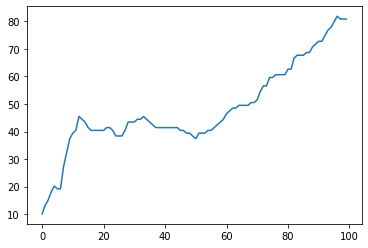

In [ ]:
#PLOTTING ACCURACY
plt.plot(accuracy)


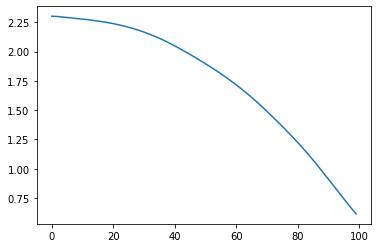

In [ ]:
#PLOTTING LOSS
plt.plot(l)

test set 


In [ ]:
#TEST SET DATALOADER
tran = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256))])
data_set = ImageFolder('/content/Test', transform = tran)
data =DataLoader(data_set, batch_size =100, shuffle=True)

In [ ]:
#TESTING 
l=[]
accuracy=[]
e=[]

for j in range(epoch):
  torch.cuda.empty_cache()
  gc.collect()
  for i, (img,lbl) in enumerate(data):
    img = img.to(device)
    lbl = lbl.to(device)
    out=net(img)
    loss=loss_fn(out,lbl)
    l.append(float(loss))
    total=lbl.size(0)
    _, predicted = torch.max(out.data , 1)
    correct = (predicted == lbl).sum().item()
    acc = correct*100/total
    accuracy.append(acc)
    if i%10 == 0:
      print(loss)
      print(acc)
    #predicted=torch.max(out.data,1)
    #loss = loss_fn(out,lbl)
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808
tensor(0.5848, device='cuda:0', grad_fn=<NllLossBackward0>)
80.8080808080808